# TP 1: LDA/QDA y optimización matemática de modelos

# Intro teórica

## Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

## Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

## LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

## Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

## Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

# Código provisto

Con el fin de no retrasar al alumno con cuestiones estructurales y/o secundarias al tema que se pretende tratar, se provee una base de código que **no es obligatoria de usar** pero se asume que resulta resulta beneficiosa.

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as LA
from scipy.linalg import cholesky, solve_triangular
from scipy.linalg.lapack import dtrtri
import matplotlib.pyplot as plt
import seaborn as sns

## Base code

In [ ]:
class BaseBayesianClassifier:
  def __init__(self):
    pass

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    '''
    Bin count sirve precisamente para hacer el calculo de las probabilidades 
    a priori tomando las frecuencias absolutas de cada clase y dividiendolas 
    por su total para tener la frecuencia relativa. 
    '''

    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?
    # _fit_params() se coloca después de calcular log_a_priori porque es necesario determinar el número de clases para poder crear las matrices de covarianza correspondientes.
    # Esto permite dimensionar correctamente las estructuras de datos que almacenarán los parámetros específicos de cada clase, haciendo el código más eficiente y organizado.

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=int)

    for i in range(m_obs):
      y_hat[i] = self._predict_one(X[:,i].reshape(-1,1))

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [3]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [LA.inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Porque flatten convierte y en un array 1D, lo que permite la comparación correcta con idx.
    # Si y es un array 2D, la comparación y==idx devolvería un array 2D de booleanos, lo que no es adecuado para indexar X.
    
    # Q6: por que se usa bias=True en vez del default bias=False?
    # Con bias=True se divide por N en vez de N-1, que da entonces el máximo verosimil. 

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?
    # Con axis=1 promedias sobre columnas, las muestras. axis=0 estaría promediando sobre features, que sería erroneo.
    
  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(LA.det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [4]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [5]:
class QDA_Chol1(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.L_invs = [
        LA.inv(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True))
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L_inv = self.L_invs[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = L_inv @ unbiased_x

    return np.log(L_inv.diagonal().prod()) -0.5 * (y**2).sum()

In [6]:
class QDA_Chol2(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.Ls = [
        cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True)
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L = self.Ls[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = solve_triangular(L, unbiased_x, lower=True)

    return -np.log(L.diagonal().prod()) -0.5 * (y**2).sum()

In [7]:
class QDA_Chol3(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.L_invs = [
        dtrtri(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True), lower=1)[0]
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L_inv = self.L_invs[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = L_inv @ unbiased_x

    return np.log(L_inv.diagonal().prod()) -0.5 * (y**2).sum()

In [8]:
# Esta fue la primera implementacion, pero creo que usar einsum saltea el paso de tener la matriz nxn que se usa en los siguientes ejercicios para seguir optimizando
class FasterQDA_einsum(TensorizedQDA):
    def predict(self, X):
        # reemplazamos resta de medias 
        tens_X_unbiased = X[None,:,:] - self.tensor_means #(1,p,n) (k,p,1) --> (k,p,n) 
        # producto interno 
        inner_prod = np.einsum('kqn,kpq,kpn->kn', tens_X_unbiased, self.tensor_inv_cov, tens_X_unbiased)
        # logaritmo de determinante
        log_dets_inv = np.array([np.linalg.slogdet(inv)[1] for inv in self.tensor_inv_cov])

        discriminants = (
            self.log_a_priori[:, None]      # (K,1)
            + 0.5 * log_dets_inv[:, None]  # (K,1)
            - 0.5 * inner_prod              # (K,n)
        )
        # clase con máximo discriminante
        return np.argmax(discriminants, axis=0)
    


In [9]:
#se calcula primero la resta de medias y luego el producto interno matricial (distancia de mahalanobis)

class FasterQDA(TensorizedQDA):
    def predict(self, X):
        # reemplazamos resta de medias 
        tens_X_unbiased = X[None,:,:] - self.tensor_means #(1,p,n) (k,p,1) --> (k,p,n) 

        #producto interno sin einsum
        A = tens_X_unbiased.transpose(0,2,1) @ self.tensor_inv_cov # (k,n,p) (k,p,p) --> (k,n,p) 
        Mahalanobis = A @ tens_X_unbiased  # (k,n,p) @ (k,p,n) -->  (k,n,n) --> Aca estan las k matrices nxn que hacen que este modelo sea optimizable aun 

        inner_prod = np.diagonal(Mahalanobis, axis1=-2, axis2=-1) # (k,n,n) --> (k,n)

        # logaritmo de determinante
        log_dets_inv = np.array([np.linalg.slogdet(inv)[1] for inv in self.tensor_inv_cov])

        discriminants = (
            self.log_a_priori[:, None]      # (K,1)
            + 0.5 * log_dets_inv[:, None]  # (K,1)
            - 0.5 * inner_prod              # (K,n)
        )
        # clase con máximo discriminante
        return np.argmax(discriminants, axis=0)
    


In [10]:
#se calcula primero la resta de medias y luego el producto interno matricial (distancia de mahalanobis)

class EfficientQDA(TensorizedQDA):
    def predict(self, X):
        # reemplazamos resta de medias 
        tens_X_unbiased = X[None,:,:] - self.tensor_means #(1,p,n) (k,p,1) --> (k,p,n) 

        #producto interno sin einsum
        A = tens_X_unbiased.transpose(0,2,1) @ self.tensor_inv_cov # (k,n,p) (k,p,p) --> (k,n,p) 
        inner_prod = np.sum(A * tens_X_unbiased.transpose(0,2,1), axis=-1)  # (k,n,p) @ (k,n,p) -->  (k,n,p) --> (k,n) --> nos evitamos k matrices nxn

        # logaritmo de determinante
        log_dets_inv = np.array([np.linalg.slogdet(inv)[1] for inv in self.tensor_inv_cov])

        discriminants = (
            self.log_a_priori[:, None]      # (K,1)
            + 0.5 * log_dets_inv[:, None]  # (K,1)
            - 0.5 * inner_prod              # (K,n)
        )
        # clase con máximo discriminante
        return np.argmax(discriminants, axis=0)
    


## Datasets

Observar que se proveen **4 datasets diferentes**, el código de ejemplo usa uno solo pero eso no significa que ustedes se limiten al mismo. También pueden usar otros datasets de su elección.

In [11]:
from sklearn.datasets import load_iris, fetch_openml, load_wine
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins_dataset():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

def get_wine_dataset():
    # get data
    data = load_wine()
    X_full = data.data
    y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
    return X_full, y_full

def get_letters_dataset():
    # get data
    letter = fetch_openml('letter', version=1, as_frame=False)
    return letter.data, letter.target.reshape(-1,1)

def label_encode(y_full):
    return LabelEncoder().fit_transform(y_full.flatten()).reshape(y_full.shape)

def split_transpose(X, y, test_size, random_state):
    # X_train, X_test, y_train, y_test but all transposed
    return [elem.T for elem in train_test_split(X, y, test_size=test_size, random_state=random_state)]

## Benchmarking

Nota: esta clase fue creada bastante rápido y no pretende ser una plataforma súper confiable sobre la que basarse, sino más bien una herramienta simple con la que poder medir varios runs y agregar la información.

En forma rápida, `warmup` es la cantidad de runs para warmup, `mem_runs` es la cantidad de runs en las que se mide el pico de uso de RAM y `n_runs` es la cantidad de runs en las que se miden tiempos.

La razón por la que se separan es que medir memoria hace ~2.5x más lento cada run, pero al mismo tiempo se estabiliza mucho más rápido.

**Importante:** tener en cuenta que los modelos que predicen en batch (usan `predict` directamente) deberían consumir, como mínimo, $n$ veces la memoria de los que predicen por observación.

In [12]:
import time
from tqdm.notebook import tqdm
from numpy.random import RandomState
import tracemalloc

RNG_SEED = 6553

class Benchmark:
    def __init__(self, X, y, n_runs=1000, warmup=100, mem_runs=100, test_sz=0.3, rng_seed=RNG_SEED, same_splits=True):
        self.X = X
        self.y = y
        self.n = n_runs
        self.warmup = warmup
        self.mem_runs = mem_runs
        self.test_sz = test_sz
        self.det = same_splits
        if self.det:
            self.rng_seed = rng_seed
        else:
            self.rng = RandomState(rng_seed)

        self.data = dict()

        print("Benching params:")
        print("Total runs:",self.warmup+self.mem_runs+self.n)
        print("Warmup runs:",self.warmup)
        print("Peak Memory usage runs:", self.mem_runs)
        print("Running time runs:", self.n)
        approx_test_sz = int(self.y.size * self.test_sz)
        print("Train size rows (approx):",self.y.size - approx_test_sz)
        print("Test size rows (approx):",approx_test_sz)
        print("Test size fraction:",self.test_sz)

    def bench(self, model_class, **kwargs):
        name = model_class.__name__
        time_data = np.empty((self.n, 3), dtype=float)  # train_time, test_time, accuracy
        mem_data = np.empty((self.mem_runs, 2), dtype=float)  # train_peak_mem, test_peak_mem
        rng = RandomState(self.rng_seed) if self.det else self.rng


        for i in range(self.warmup):
            # Instantiate model with error check for unsupported parameters
            model = model_class(**kwargs)

            # Generate current train-test split
            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )
            # Run training and prediction (timing or memory measurement not recorded)
            model.fit(X_train, y_train)
            model.predict(X_test)

        for i in tqdm(range(self.mem_runs), total=self.mem_runs, desc=f"{name} (MEM)"):

            model = model_class(**kwargs)

            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )

            tracemalloc.start()

            t1 = time.perf_counter()
            model.fit(X_train, y_train)
            t2 = time.perf_counter()

            _, train_peak = tracemalloc.get_traced_memory()
            tracemalloc.reset_peak()

            model.predict(X_test)
            t3 = time.perf_counter()
            _, test_peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            mem_data[i,] = (
                train_peak / (1024 * 1024),
                test_peak / (1024 * 1024)
            )

        for i in tqdm(range(self.n), total=self.n, desc=f"{name} (TIME)"):
            model = model_class(**kwargs)

            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )

            t1 = time.perf_counter()
            model.fit(X_train, y_train)
            t2 = time.perf_counter()
            preds = model.predict(X_test)
            t3 = time.perf_counter()

            time_data[i,] = (
                (t2 - t1) * 1000,
                (t3 - t2) * 1000,
                (y_test.flatten() == preds.flatten()).mean()
            )

        self.data[name] = (time_data, mem_data)

    def summary(self, baseline=None):
        aux = []
        for name, (time_data, mem_data) in self.data.items():
            result = {
                'model': name,
                'train_median_ms': np.median(time_data[:, 0]),
                'train_std_ms': time_data[:, 0].std(),
                'test_median_ms': np.median(time_data[:, 1]),
                'test_std_ms': time_data[:, 1].std(),
                'mean_accuracy': time_data[:, 2].mean(),
                'train_mem_median_mb': np.median(mem_data[:, 0]),
                'train_mem_std_mb': mem_data[:, 0].std(),
                'test_mem_median_mb': np.median(mem_data[:, 1]),
                'test_mem_std_mb': mem_data[:, 1].std()
            }
            aux.append(result)
        df = pd.DataFrame(aux).set_index('model')

        if baseline is not None and baseline in self.data:
            df['train_speedup'] = df.loc[baseline, 'train_median_ms'] / df['train_median_ms']
            df['test_speedup'] = df.loc[baseline, 'test_median_ms'] / df['test_median_ms']
            df['train_mem_reduction'] = df.loc[baseline, 'train_mem_median_mb'] / df['train_mem_median_mb']
            df['test_mem_reduction'] = df.loc[baseline, 'test_mem_median_mb'] / df['test_mem_median_mb']
        return df
    
    def plot_superposed(self, baseline=None, metric_group='time'):
        """
        Dibuja gráficos con curvas superpuestas y hue, usando seaborn.
        metric_group: 'time' | 'memory' | 'accuracy'
        """
        df = self.summary(baseline=baseline).reset_index()

        # Armamos datos en formato largo (tidy) para seaborn
        records = []
        for _, row in df.iterrows():
            model = row['model']
            if metric_group == 'time':
                records.append({'model': model, 'phase': 'train', 'value': row['train_median_ms'],
                                'std': row['train_std_ms']})
                records.append({'model': model, 'phase': 'test', 'value': row['test_median_ms'],
                                'std': row['test_std_ms']})
            elif metric_group == 'memory':
                records.append({'model': model, 'phase': 'train', 'value': row['train_mem_median_mb'],
                                'std': row['train_mem_std_mb']})
                records.append({'model': model, 'phase': 'test', 'value': row['test_mem_median_mb'],
                                'std': row['test_mem_std_mb']})
            elif metric_group == 'accuracy':
                records.append({'model': model, 'phase': 'accuracy', 'value': row['mean_accuracy'],
                                'std': row.get('std_accuracy', None)})

        long_df = pd.DataFrame.from_records(records)

        # Graficamos: eje x = modelo, y = métrica, hue = fase (train/test/accuracy)
        plt.figure(figsize=(8,5))
        sns.pointplot(
            data=long_df, x='model', y='value', hue='phase',
            errorbar=('sd', 1), dodge=True, markers='o', capsize=0.1
        )
        plt.title(f'{metric_group.capitalize()} curves (median ± std)')
        plt.xlabel('Model')
        if metric_group == 'time':
            plt.ylabel('ms')
        elif metric_group == 'memory':
            plt.ylabel('MiB')
        else:
            plt.ylabel('accuracy')
        plt.xticks(rotation=30, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## Ejemplo

In [13]:
# levantamos el dataset Wine, que tiene 13 features y 178 observaciones en total
X_full, y_full = get_penguins_dataset()

X_full.shape, y_full.shape

((342, 4), (342, 1))

In [14]:
# encodeamos a número las clases
y_full_encoded = label_encode(y_full)

y_full[:5], y_full_encoded[:5]

(array([['Adelie'],
        ['Adelie'],
        ['Adelie'],
        ['Adelie'],
        ['Adelie']], dtype=object),
 array([[0],
        [0],
        [0],
        [0],
        [0]]))

In [15]:
# generamos el benchmark
# observar que son valores muy bajos de runs para que corra rápido ahora
b = Benchmark(
    X_full, y_full_encoded,
    n_runs = 1000,
    warmup = 500,
    mem_runs = 1000,
    test_sz = 0.3,
    same_splits = False
)

Benching params:
Total runs: 2500
Warmup runs: 500
Peak Memory usage runs: 1000
Running time runs: 1000
Train size rows (approx): 240
Test size rows (approx): 102
Test size fraction: 0.3


In [16]:
# bencheamos un par
to_bench = [QDA]

for model in to_bench:
    b.bench(model)

QDA (MEM):   0%|          | 0/1000 [00:00<?, ?it/s]

QDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
# como es una clase, podemos seguir bencheando más después
b.bench(TensorizedQDA)

TensorizedQDA (MEM):   0%|          | 0/1000 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
b.bench(FasterQDA)

FasterQDA (MEM):   0%|          | 0/1000 [00:00<?, ?it/s]

FasterQDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
b.bench(EfficientQDA)

EfficientQDA (MEM):   0%|          | 0/1000 [00:00<?, ?it/s]

EfficientQDA (TIME):   0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
# hacemos un summary
b.summary()

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb
model,,,,,,,,,
QDA,0.067354,0.057264,1.278916,0.133080,0.986262,0.011513,0.000381,0.004423,0.000226
TensorizedQDA,0.071020,0.016749,0.518417,0.121877,0.986893,0.011421,0.000371,0.004539,0.000132
FasterQDA,0.068375,0.009299,0.027917,0.007962,0.986699,0.011513,0.000354,0.272674,0.000096
EfficientQDA,0.068833,0.008887,0.021250,0.008296,0.986942,0.011421,0.000369,0.033936,0.000105


In [21]:
# son muchos datos! nos quedamos con un par nomás
summ = b.summary()

# como es un pandas DataFrame, subseteamos columnas fácil
summ[['train_median_ms', 'test_median_ms','mean_accuracy']]

,train_median_ms,test_median_ms,mean_accuracy
model,,,
QDA,0.067354,1.278916,0.986262
TensorizedQDA,0.071020,0.518417,0.986893
FasterQDA,0.068375,0.027917,0.986699
EfficientQDA,0.068833,0.021250,0.986942


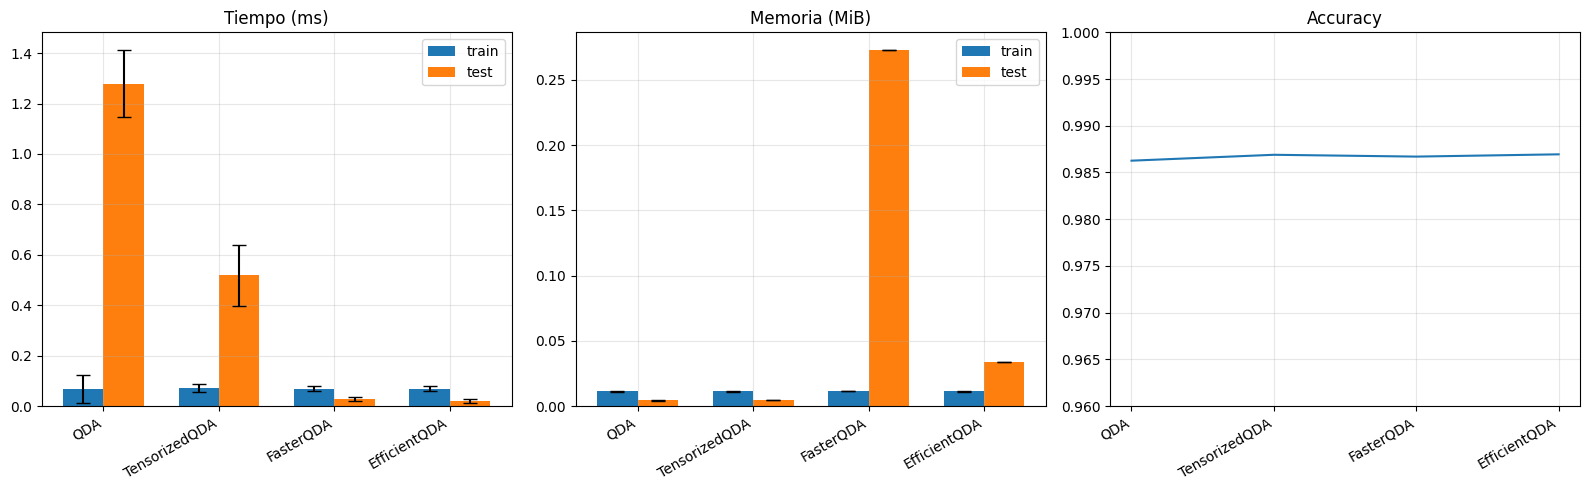

In [22]:
df = summ.copy()   # tu tabla con index='model'

models = df.index.tolist()

# --- 1) Tiempo ---
x = np.arange(len(models))
width = 0.35

fig, axes = plt.subplots(1, 3, figsize=(16,5))

axes[0].bar(x - width/2, df['train_median_ms'], width, 
            yerr=df['train_std_ms'], label='train', capsize=5)
axes[0].bar(x + width/2, df['test_median_ms'], width, 
            yerr=df['test_std_ms'], label='test', capsize=5)
axes[0].set_title("Tiempo (ms)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=30, ha='right')
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- 2) Memoria ---
axes[1].bar(x - width/2, df['train_mem_median_mb'], width, 
            yerr=df['train_mem_std_mb'], label='train', capsize=5)
axes[1].bar(x + width/2, df['test_mem_median_mb'], width, 
            yerr=df['test_mem_std_mb'], label='test', capsize=5)
axes[1].set_title("Memoria (MiB)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=30, ha='right')
axes[1].legend()
axes[1].grid(alpha=0.3)

# --- 3) Accuracy ---
axes[2].plot(x, df['mean_accuracy'], width)
axes[2].set_title("Accuracy")
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=30, ha='right')
axes[2].set_ylim(0.96,1)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:
# podemos setear un baseline para que fabrique columnas de comparación
summ = b.summary(baseline='QDA')

summ

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,,,,,,,,,,
QDA,0.067354,0.057264,1.278916,0.133080,0.986262,0.011513,0.000381,0.004423,0.000226,1.000000,1.000000,1.000000,1.000000
TensorizedQDA,0.071020,0.016749,0.518417,0.121877,0.986893,0.011421,0.000371,0.004539,0.000132,0.948374,2.466966,1.008016,0.974370
FasterQDA,0.068375,0.009299,0.027917,0.007962,0.986699,0.011513,0.000354,0.272674,0.000096,0.985068,45.811370,1.000000,0.016221
EfficientQDA,0.068833,0.008887,0.021250,0.008296,0.986942,0.011421,0.000369,0.033936,0.000105,0.978513,60.184283,1.008016,0.130339


# Consigna QDA

**Notación**: en general notamos

* $k$ la cantidad de clases
* $n$ la cantidad de observaciones
* $p$ la cantidad de features/variables/predictores

**Sugerencia:** combinaciones adecuadas de `transpose`, `stack`, `reshape` y, ocasionalmente, `flatten` y `diagonal` suele ser más que suficiente. Se recomienda *fuertemente* explorar la dimensionalidad de cada elemento antes de implementar las clases.

## Tensorización

En esta sección nos vamos a ocupar de hacer que el modelo sea más rápido para generar predicciones, observando que incurre en un doble `for` dado que predice en forma individual un escalar para cada observación, para cada clase. Paralelizar ambos vía tensorización suena como una gran vía de mejora de tiempos.

### 1) Diferencias entre `QDA`y `TensorizedQDA`

1. ¿Sobre qué paraleliza `TensorizedQDA`? ¿Sobre las $k$ clases, las $n$ observaciones a predecir, o ambas?
2. Analizar los shapes de `tensor_inv_covs` y `tensor_means` y explicar paso a paso cómo es que `TensorizedQDA` llega a predecir lo mismo que `QDA`.

### 2) Optimización

Debido a la forma cuadrática de QDA, no se puede predecir para $n$ observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de $n \times n$ en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

3. Implementar el modelo `FasterQDA` (se recomienda heredarlo de `TensorizedQDA`) de manera de eliminar el ciclo for en el método predict.
4. Mostrar dónde aparece la mencionada matriz de $n \times n$, donde $n$ es la cantidad de observaciones a predecir.
5. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de $n \times n$ usando matrices de $n \times p$. También se puede usar, de forma equivalente,
$$
np.sum(A^T \odot B, axis=0).T
$$
queda a preferencia del alumno cuál usar.

6. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente en un nuevo modelo `EfficientQDA`.
7. Comparar la performance de las 4 variantes de QDA implementadas hasta ahora (no Cholesky) ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

## Cholesky

Hasta ahora todos los esfuerzos fueron enfocados en realizar una predicción más rápida. Los tiempos de entrenamiento (teóricos al menos) siguen siendo los mismos o hasta (minúsculamente) peores, dado que todas las mejoras siguen llamando al método `_fit_params` original de `QDA`.

La descomposición/factorización de [Cholesky](https://en.wikipedia.org/wiki/Cholesky_decomposition#Statement) permite factorizar una matriz definida positiva $A = LL^T$ donde $L$ es una matriz triangular inferior. En particular, si bien se asume que $p \ll n$, invertir la matriz de covarianzas $\Sigma$ para cada clase impone un cuello de botella que podría alivianarse. Teniendo en cuenta que las matrices de covarianza son simétricas y salvo degeneración, definidas positivas, Cholesky como mínimo debería permitir invertir la matriz más rápido.

*Nota: observar que calcular* $A^{-1}b$ *equivale a resolver el sistema* $Ax=b$.

### 3) Diferencias entre implementaciones de `QDA_Chol`

8. Si una matriz $A$ tiene fact. de Cholesky $A=LL^T$, expresar $A^{-1}$ en términos de $L$. ¿Cómo podría esto ser útil en la forma cuadrática de QDA?
7. Explicar las diferencias entre `QDA_Chol1`y `QDA` y cómo `QDA_Chol1` llega, paso a paso, hasta las predicciones.
8. ¿Cuáles son las diferencias entre `QDA_Chol1`, `QDA_Chol2` y `QDA_Chol3`?
9. Comparar la performance de las 7 variantes de QDA implementadas hasta ahora ¿Qué se observa?¿Hay alguna de las implementaciones de `QDA_Chol` que sea claramente mejor que las demás?¿Alguna que sea peor?

### 4) Optimización

12. Implementar el modelo `TensorizedChol` paralelizando sobre clases/observaciones según corresponda. Se recomienda heredarlo de alguna de las implementaciones de `QDA_Chol`, aunque la elección de cuál de ellas queda a cargo del alumno según lo observado en los benchmarks de puntos anteriores.
13. Implementar el modelo `EfficientChol` combinando los insights de `EfficientQDA` y `TensorizedChol`. Si se desea, se puede implementar `FasterChol` como ayuda, pero no se contempla para el punto.
13. Comparar la performance de las 9 variantes de QDA implementadas ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

## Importante:

Las métricas que se observan al realizar benchmarking son muy dependientes del código que se ejecuta, y por tanto de las versiones de las librerías utilizadas. Una forma de unificar esto es utilizando un gestor de versiones y paquetes como _uv_ o _Poetry_, otra es simplemente usando una misma VM como la que provee Colab.

**Cada equipo debe informar las versiones de Python, NumPy y SciPy con que fueron obtenidos los resultados. En caso de que sean múltiples, agregar todos los casos**. La siguiente celda provee una ayuda para hacerlo desde un notebook, aunque como es una secuencia de comandos también sirve para consola.

In [25]:
%%bash
python --version
pip freeze | grep -E "scipy|numpy"

Python 3.11.13
numpy==2.3.2
scipy==1.16.1


**Comentario:** yo utilicé los siguientes parámetros para mi run de prueba. Esto NO significa que ustedes tengan que usar los mismos, tampoco el mismo dataset. Se agregó al notebook simplemente porque fue una pregunta común en cohortes anteriores.

In [26]:
# dataset de letters
X_letter, y_letter = get_letters_dataset()

# encoding de labels
y_letter_encoded = label_encode(y_letter.reshape(-1,1))

# instanciacion del benchmark
b = Benchmark(
    X_letter, y_letter_encoded,
    same_splits=False,
    n_runs=100,
    warmup=20,
    mem_runs=30,
    test_sz=0.2
)

Benching params:
Total runs: 150
Warmup runs: 20
Peak Memory usage runs: 30
Running time runs: 100
Train size rows (approx): 16000
Test size rows (approx): 4000
Test size fraction: 0.2
